# Financial data downloading and analysis

This notebook presents the Finviz spider implemented in python and a basic stock screener for a value strategy investment. 

The spider can be initialized by loading the class [FinvizSpider](Spider.py). To download data, just execute:

In [ ]:
from Spider import FinvizSpider

spider = FinvizSpider()
spider.scrape_data(max_pages='all')   # put 'all' or an integer: e.g. 5
data = spider.clean_data()

Loading a backup .csv of the data:

In [7]:
import pandas as pd

data = pd.DataFrame.from_csv('Finviz_data_20190701_1307.csv')
data.head()

/home/diego/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


,No.,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Fwd P/E,PEG,...,Gap,Recom,Avg Volume,Rel Volume,Price,Change,Volume,Earnings,Target Price,IPO Date
0,1,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,2.367000e+13,21.18,21.96,2.0,...,0.10,1.8,2530000.0,1.26,74.67,2.02,3159736.0,Aug 13/a,83.64,11/18/1999
1,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,4.290000e+12,NaN,9.85,NaN,...,-0.13,2.1,3440000.0,0.85,23.41,1.21,2910116.0,Jul 17/a,34.75,1/2/1962
2,3,AAAU,Perth Mint Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,NaN,NaN,...,0.14,NaN,38900.0,0.25,14.10,0.28,9733.0,-,NaN,8/15/2018
3,4,AABA,Altaba Inc.,Financial,Asset Management,USA,6.561000e+13,NaN,NaN,NaN,...,0.03,3.0,7710000.0,1.21,69.37,-0.86,9033122.0,-,76.00,4/12/1996
4,5,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,2.100000e+07,NaN,13.23,NaN,...,3.59,1.5,406880.0,4.48,0.86,3.59,1712915.0,Aug 08/b,4.50,10/2/2014


Let's check the data structure for the stock 'DATA' (Tableau):

In [18]:
data.columns

Index(['No.', 'Ticker', 'Company', 'Sector', 'Industry', 'Country',
       'Market Cap', 'P/E', 'Fwd P/E', 'PEG', 'P/S', 'P/B', 'P/C', 'P/FCF',
       'Dividend', 'Payout Ratio', 'EPS', 'EPS this Y', 'EPS next Y',
       'EPS past 5Y', 'EPS next 5Y', 'Sales past 5Y', 'EPS Q/Q', 'Sales Q/Q',
       'Outstanding', 'Float', 'Insider Own', 'Insider Trans', 'Inst Own',
       'Inst Trans', 'Float Short', 'Short Ratio', 'ROA', 'ROE', 'ROI',
       'Curr R', 'Quick R', 'LTDebt/Eq', 'Debt/Eq', 'Gross M', 'Oper M',
       'Profit M', 'Perf Week', 'Perf Month', 'Perf Quart', 'Perf Half',
       'Perf Year', 'Perf YTD', 'Beta', 'ATR', 'Volatility W', 'Volatility M',
       'SMA20', 'SMA50', 'SMA200', '50D High', '50D Low', '52W High',
       '52W Low', 'RSI', 'from Open', 'Gap', 'Recom', 'Avg Volume',
       'Rel Volume', 'Price', 'Change', 'Volume', 'Earnings', 'Target Price',
       'IPO Date'],
      dtype='object')

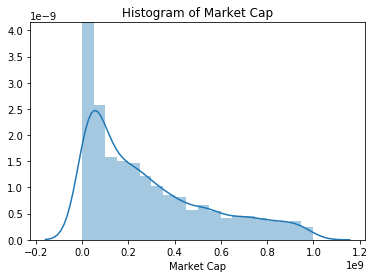

In [51]:
p = sns.distplot(data['Market Cap'][data['Market Cap'] < 1e10])
p.set(title='Histogram of Market Cap')
p

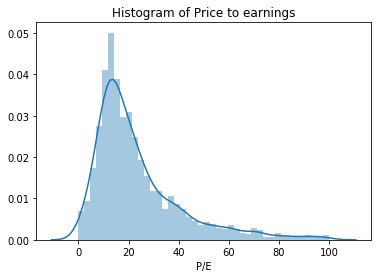

In [52]:
p = sns.distplot(data['P/E'][data['P/E'] < 100])
p.set(title='Histogram of Price to earnings')
p

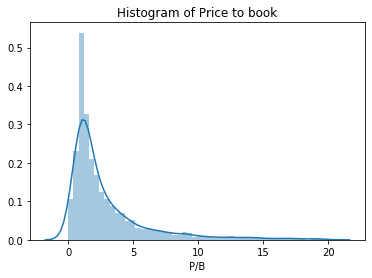

In [54]:
p = sns.distplot(data['P/B'][data['P/B'] < 20])
p.set(title='Histogram of Price to book')
p

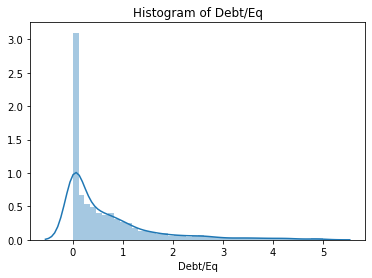

In [57]:
p = sns.distplot(data['Debt/Eq'][data['Debt/Eq'] < 5])
p.set(title='Histogram of Debt/Eq')
p

Let's select the stocks with lower 'P/E', 'P/B', 'Debt/Eq' and 'Market Cap' > 100,000

In [28]:
data.iloc[869][['P/E', 'P/B', 'Debt/Eq', 'Market Cap']]

P/E                 0.01
P/B                    0
Debt/Eq              NaN
Market Cap    5.2588e+14
Name: 869, dtype: object

## Screening the best stocks

In [78]:
mask_mkt_cap = (1e8 > data['Market Cap']) & (data['Market Cap'] < 3e8)
mask_pe = data['P/E'] < 30
mask_pb = data['P/B'] < 4
mask_debt = data['Debt/Eq'] < 1
mask = mask_mkt_cap & mask_pe & mask_pb & mask_debt
print(f'Total tickers selected: {sum(mask)}')

Total tickers selected: 136


Rank the selected tickers by a composed index:

In [89]:
sel = data[mask].copy()  # selected tickers
sel['index'] = 0.25 * sel['Market Cap'].rank() + 0.25 * sel['P/E'].rank() + \
               0.25 * sel['P/B'].rank() + 0.25 * sel['Debt/Eq'].rank()
sel.loc[:, ['Ticker', 'Company', 'Sector', 'Industry', 'Market Cap', 'P/E', 'P/B', 'Debt/Eq', 'index']].sort_values('index').head(10)

,Ticker,Company,Sector,Industry,Market Cap,P/E,P/B,Debt/Eq,index
4931,NTZ,Natuzzi S.p.A.,Consumer Goods,Home Furnishings & Fixtures,25700000.0,0.69,0.18,0.00,17.000
6703,THST,"Truett-Hurst, Inc.",Consumer Goods,Beverages - Wineries & Distillers,6120000.0,2.26,0.59,0.00,17.500
666,BDR,"Blonder Tongue Laboratories, Inc.",Technology,Communication Equipment,9000000.0,2.50,0.72,0.00,20.875
4959,NVFY,"Nova LifeStyle, Inc.",Consumer Goods,Home Furnishings & Fixtures,20800000.0,5.43,0.27,0.00,21.000
7585,XTLB,XTL Biopharmaceuticals Ltd.,Healthcare,Biotechnology,10280000.0,1.72,0.84,0.00,23.000
6096,SDT,SandRidge Mississippian Trust I,Basic Materials,Independent Oil & Gas,18100000.0,3.45,0.67,0.00,24.875
4524,MN,"Manning & Napier, Inc.",Financial,Asset Management,27700000.0,8.50,0.16,0.00,29.000
3627,INPX,Inpixon,Technology,Application Software,7000000.0,0.04,0.22,0.32,30.000
6093,SDR,SandRidge Mississippian Trust II,Basic Materials,Independent Oil & Gas,31200000.0,3.26,0.76,0.00,30.250
1559,CUO,Continental Materials Corporation,Industrial Goods,Diversified Machinery,27680000.0,2.90,0.44,0.01,30.625


## To do: 
  - Modify the screening of stocks using also those with missing values
  - Get the intraday price historic for the selected stocks
  - Analyse the investment strategy backtesting using `pyfolio`:

In [7]:
import pyfolio as pf

?pf.create_position_tear_sheet